# Linear regression with iterative optimization: SGDRegressor

SGD offers a lot of control over optimization procedure through a number of hyperparameters. However, we need to set them to right values in order to make it work for training the model.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [24]:
# set the random seed
np.random.seed(306)

In [25]:
# use shuffle split as cv strategy:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

In [26]:
# Lets load the data and split into training and test

features, labels = fetch_california_housing(as_frame = True, 
                                            return_X_y = True)
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features,
                                                                                    labels,
                                                                                    random_state = 42)


In [27]:
# divide the training data into train and dev sets
# dev part can be used for tuning the hyperparameters
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state = 42)


# Baseline SGDRegressor

In [28]:
# Step 1 : To begin with we instantiate a baseline SGDRegressor model with default parameters
# Step 2 : Train the model with training feature matrix and labels
# Step 3 : Obtain the score on the training and devel data.

In [29]:
sgd = SGDRegressor(random_state = 42)
sgd.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd.predict(dev_features))
print ("Mean absolute error on Training set: ", train_mae)
print ("Mean absolute error on development set: ", dev_mae)

Mean absolute error on Training set:  327898229800533.8
Mean absolute error on development set:  331110341291405.44


We can observe that the mean absolute error is too high. The baseline model does not train well.
This may happen due to large learning rate. Let's investigate this issue by training the model
step by step and recording training loss in each step.

# Adding a feature scaling step:



In [30]:
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                         ("sgd", SGDRegressor())])
sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print(train_mae)
print(dev_mae)

0.5135804404077051
0.6373131245753217


The error is still high, let's run SGDRegressor step by step and investigate issues with training.

# Step wise training of SGDRegressor

STEP 1: Instantiate SGDRegressor with warm_start=True and tol=-np.infty .

STEP 2: Train SGD step by step and record regression loss in each step.

STEP 3: Plot learning curves and see if there are any issues in training.

Text(0.5, 1.0, 'Learning curve: eta0=0.0100')

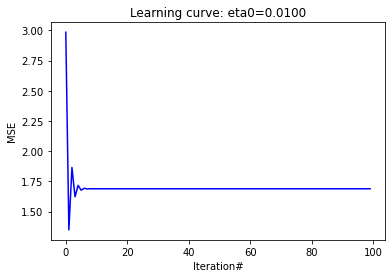

In [31]:
eta0 = 1e-2
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                         ("SGD", SGDRegressor(max_iter=1,
                                              tol=-np.infty,
                                              warm_start=True,
                                              random_state=42))])

loss = []

for epoch in range(100):
  sgd_pipeline.fit(train_features, train_labels) # continues where it left off
  loss.append(mean_squared_error(train_labels,
                                 sgd_pipeline.predict(train_features)))

plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel('Iteration#')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0:.4f}')

In [32]:
# The loss reduced initialy and then increased. This could be due to large learning rates. We will
# reduce the learning rate by a factor of 10 and retry the training.



Text(0.5, 1.0, 'Learning curve: eta0=0.0010')

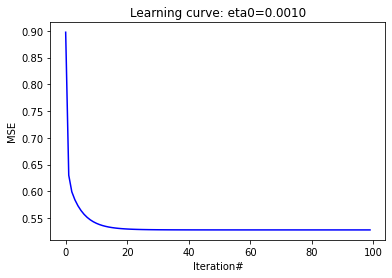

In [33]:
eta0 = 1e-3
# using invscaling the learning rate is reduced in every step

sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                         ("SGD", SGDRegressor(max_iter=1,
                                              tol=-np.infty,
                                              warm_start=True,
                                              eta0=eta0,
                                              random_state=42))])

loss = []

for epoch in range(100):
  sgd_pipeline.fit(train_features, train_labels) # continues where it left off
  loss.append(mean_squared_error(train_labels,
                                 sgd_pipeline.predict(train_features)))
  
plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel('Iteration#')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0:.4f}')

This is an ideal learning curve where the train loss reduces monotonically as the training
progresses.

In [34]:
print ("#iteration before reaching convergence criteria:",sgd_pipeline[-1].n_iter_)
print ("#weight updates:", sgd_pipeline[-1].t_)

#iteration before reaching convergence criteria: 1
#weight updates: 11611.0


In [35]:
train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print ("Mean absolute error on Training set: ", train_mae)
print ("Mean absolute error on development set: ", dev_mae)

Mean absolute error on Training set:  0.5333732983042573
Mean absolute error on development set:  0.5190150280908042


# Fixing learning rate through validation curves

Alternate way

STEP 1: Provide the list of values to be tried for a hyper-parameter.

STEP 2: Instantiate an object of validation_curve with estimator, training features and
label. Set scoring parameter to relevant score.
Fixing learning rate through validation curves

STEP 3: Convert scores to error

STEP 4: Plot validation curve with the value of hyper-parameter on x-axis and error on the
y-axis.

STEP 5: Fix the hyper-parameter value where the test error is the least.

In [36]:
%%time
eta0 = [1e-5, 1e-4, 1e-3, 1e-2] # provide values in ascending values
train_scores, test_scores = validation_curve(sgd_pipeline, 
                                             com_train_features, 
                                             com_train_labels, 
                                             param_name="SGD__eta0",
                                             param_range=eta0, 
                                             cv=shuffle_split_cv,
                                             scoring="neg_mean_squared_error",
                                             n_jobs=2)
train_errors, test_errors = -train_scores, -test_scores

CPU times: user 178 ms, sys: 156 ms, total: 335 ms
Wall time: 2.38 s


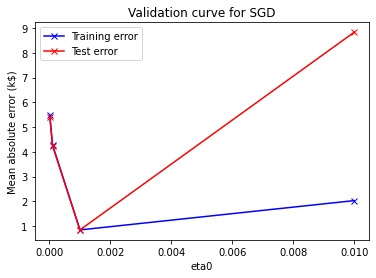

In [37]:
train_errors, test_errors = -train_scores, -test_scores
plt.plot(eta0, train_errors.mean(axis=1), 'b-x', label="Training error")
plt.plot(eta0, test_errors.mean(axis=1), 'r-x', label="Test error")
plt.legend()
plt.xlabel("eta0")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve for SGD")

For eta0=1e-3 , the test error is the least and hence we select that value as the value for eta0 .

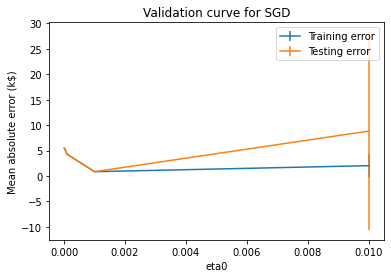

In [38]:
plt.errorbar(eta0, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1),
             label='Training error')

plt.errorbar(eta0, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1),
             label='Testing error')

plt.legend()
plt.xlabel("eta0")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve for SGD")

# SGDRegressor

In [39]:
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                         ("sgd", SGDRegressor(max_iter=500,
                                              early_stopping=True,
                                              eta0=1e-3,
                                              tol=1e-3,
                                              validation_fraction=0.2,
                                              n_iter_no_change=5,
                                              average=10,
                                              random_state=42))])
sgd_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('sgd',
                 SGDRegressor(average=10, early_stopping=True, eta0=0.001,
                              max_iter=500, random_state=42,
                              validation_fraction=0.2))])

In [40]:
train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print ("Mean absolute error on Training set: ", train_mae)
print ("Mean absolute error on development set: ", dev_mae)

Mean absolute error on Training set:  0.579376454514559
Mean absolute error on development set:  0.5689180241137523


In [41]:
print ("Number of SGD iterations: ", sgd_pipeline[-1].n_iter_)
print ("Number of weight updates: ", sgd_pipeline[-1].t_)

Number of SGD iterations:  7
Number of weight updates:  81271.0


In [42]:
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                         ("sgd", SGDRegressor(max_iter=500,
                                              early_stopping=True,
                                              eta0=1e-3,
                                              tol=1e-3,
                                              learning_rate='constant',
                                              validation_fraction=0.2,
                                              n_iter_no_change=5,
                                              average=10,
                                              random_state=42))])
sgd_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('sgd',
                 SGDRegressor(average=10, early_stopping=True, eta0=0.001,
                              learning_rate='constant', max_iter=500,
                              random_state=42, validation_fraction=0.2))])

In [43]:

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print ("Mean absolute error on Training set: ", train_mae)
print ("Mean absolute error on development set: ", dev_mae)

Mean absolute error on Training set:  0.5359339681114987
Mean absolute error on development set:  0.5151099728924144


# Setting max_iters

In [44]:
max_iter = np.ceil(1e6/com_train_features.shape[0])
max_iter

65.0

In [45]:
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
("sgd", SGDRegressor(max_iter=max_iter,
early_stopping=True,
eta0=1e-3,
tol=1e-3,
learning_rate='constant',
validation_fraction=0.2,
n_iter_no_change=5,
average=10,
random_state=42))])
sgd_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('sgd',
                 SGDRegressor(average=10, early_stopping=True, eta0=0.001,
                              learning_rate='constant', max_iter=65.0,
                              random_state=42, validation_fraction=0.2))])

In [46]:
train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print ("Mean absolute error on Training set: ", train_mae)
print ("Mean absolute error on development set: ", dev_mae)

Mean absolute error on Training set:  0.5359339681114987
Mean absolute error on development set:  0.5151099728924144


In [47]:
print ("\nNumber of SGD iterations: ", sgd_pipeline[-1].n_iter_)
print ("Number of weight updates: ", sgd_pipeline[-1].t_)


Number of SGD iterations:  8
Number of weight updates:  92881.0


In this notebook, we saw:

how to build SGDRegreesor model.

1.   how to tune the learning rate.
2.   how to use different learning_rate s and their impact on convergence.
3. how to use early stopping and averaged SGD.
4. how to tune hyperparameters with validation curves.








